<a href="https://colab.research.google.com/github/hitesh-bhatnagar/EEG_Epileptic_Seizure_Detection/blob/main/EEG_Epileptic_Seizure_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import os
import zipfile
!pip install kaggle

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout


In [3]:
# Upload kaggle API file (kaggle.json)
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"hiteshbhatnagar","key":"e201a58ba519471d1d6c10af03d3d68e"}'}

In [4]:
# Move kaggle.json file to the correct directory
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [5]:
# Downloading the dataset
!kaggle datasets download -d adibadea/chbmitseizuredataset

Dataset URL: https://www.kaggle.com/datasets/adibadea/chbmitseizuredataset
License(s): GNU Affero General Public License 3.0
 98% 625M/635M [00:09<00:00, 63.2MB/s]
100% 635M/635M [00:09<00:00, 72.0MB/s]


In [6]:
os.listdir()

['.config', 'kaggle.json', 'chbmitseizuredataset.zip', 'sample_data']

In [7]:
# create a folder datasets
!mkdir -p /content/datasets

# unzip dataset file into datasets directory
!unzip -q /content/chbmitseizuredataset.zip -d /content/datasets

In [8]:
os.listdir('/content')

['.config',
 'kaggle.json',
 'datasets',
 'chbmitseizuredataset.zip',
 'sample_data']

In [9]:
os.listdir('/content/datasets')

['eeg-seizure_val_balanced.npz',
 'eeg-seizure_train.npz',
 'eeg-predictive_val.npz',
 'eeg-predictive_val_balanced.npz',
 'eeg-predictive_train.npz',
 'eeg-seizure_test.npz',
 'eeg-seizure_val.npz']

In [11]:
# Load the data from .npz files

train_data = np.load('/content/datasets/eeg-seizure_train.npz')
val_data = np.load('/content/datasets/eeg-seizure_val_balanced.npz')
test_data = np.load('/content/datasets/eeg-seizure_test.npz')


In [12]:
print(train_data.files)
print(val_data.files)
print(test_data.files)

['train_signals', 'train_labels']
['val_signals', 'val_labels']
['test_signals']


In [13]:
# Extract EEG signals and labels

X_train = train_data['train_signals']
y_train = train_data['train_labels']
X_val = val_data['val_signals']
y_val = val_data['val_labels']
X_test = test_data['test_signals']

In [14]:
# Convert to TensorFlow tensors
X_train = tf.convert_to_tensor(X_train, dtype=tf.float32)
y_train = tf.convert_to_tensor(y_train, dtype=tf.float32)
X_val = tf.convert_to_tensor(X_val, dtype=tf.float32)
y_val = tf.convert_to_tensor(y_val, dtype=tf.float32)
X_test = tf.convert_to_tensor(X_test, dtype=tf.float32)


In [15]:
print (X_train.shape)
print(y_train.shape)
print(X_val.shape)
print(y_val.shape)
print(X_test.shape)

(37666, 23, 256)
(37666,)
(3546, 23, 256)
(3546,)
(8072, 23, 256)


In [16]:
# Normalization of the input data

X_train = tf.image.per_image_standardization(X_train)
X_val = tf.image.per_image_standardization(X_val)
X_test = tf.image.per_image_standardization(X_test)

In [17]:
print(X_train.shape)
print(X_val.shape)
print(X_test.shape)

(37666, 23, 256)
(3546, 23, 256)
(8072, 23, 256)


In [18]:
# Reshape for CNN input (num_samples/batch_size, height, width, channels)

# -1 in the shape argument allows TensorFlow to automatically infer the size of that dimension based on the total number of elements in the tensor and the other specified dimensions.
# 23 corresponds to the number of channels or features
# 256 number of time steps or sequence length
# 1 indicates that there is only one channel. like if the data has multiple channels per feature like (RGB or RGBA images) then adjust the number
X_train_cnn = tf.reshape(X_train, [-1, 23, 256, 1])
X_val_cnn = tf.reshape(X_val, [-1, 23, 256, 1])
X_test_cnn = tf.reshape(X_test, [-1, 23, 256, 1])

print(X_train_cnn.shape)
print(X_val_cnn.shape)
print(X_test_cnn.shape)

(37666, 23, 256, 1)
(3546, 23, 256, 1)
(8072, 23, 256, 1)


In [19]:
# Data augmentation generator

datagen = ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)
datagen.fit(X_train_cnn)

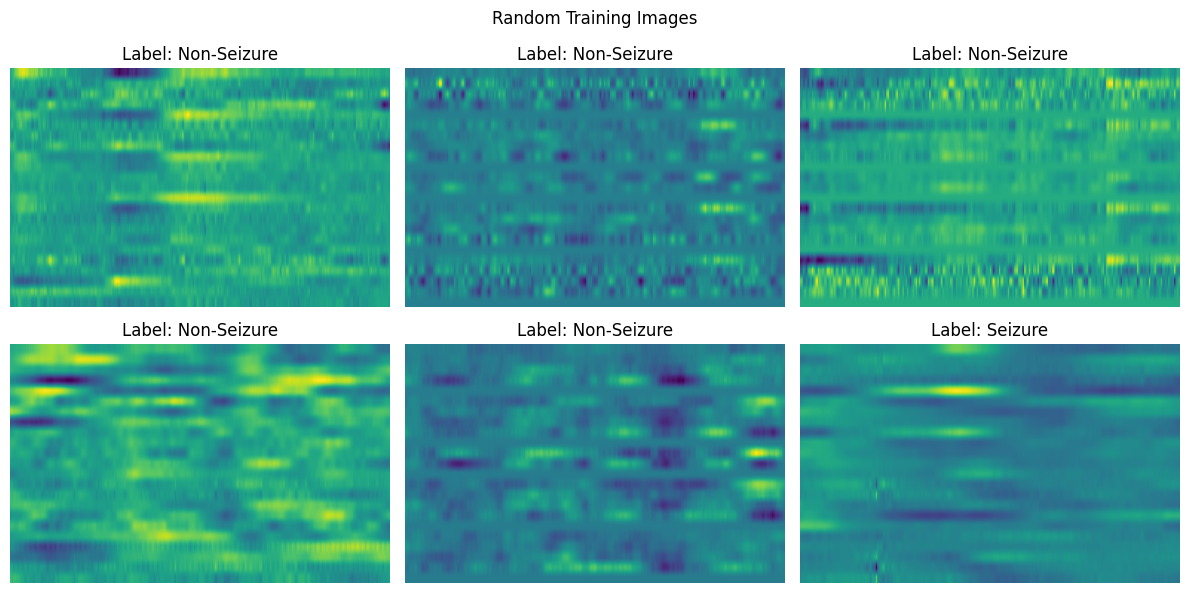

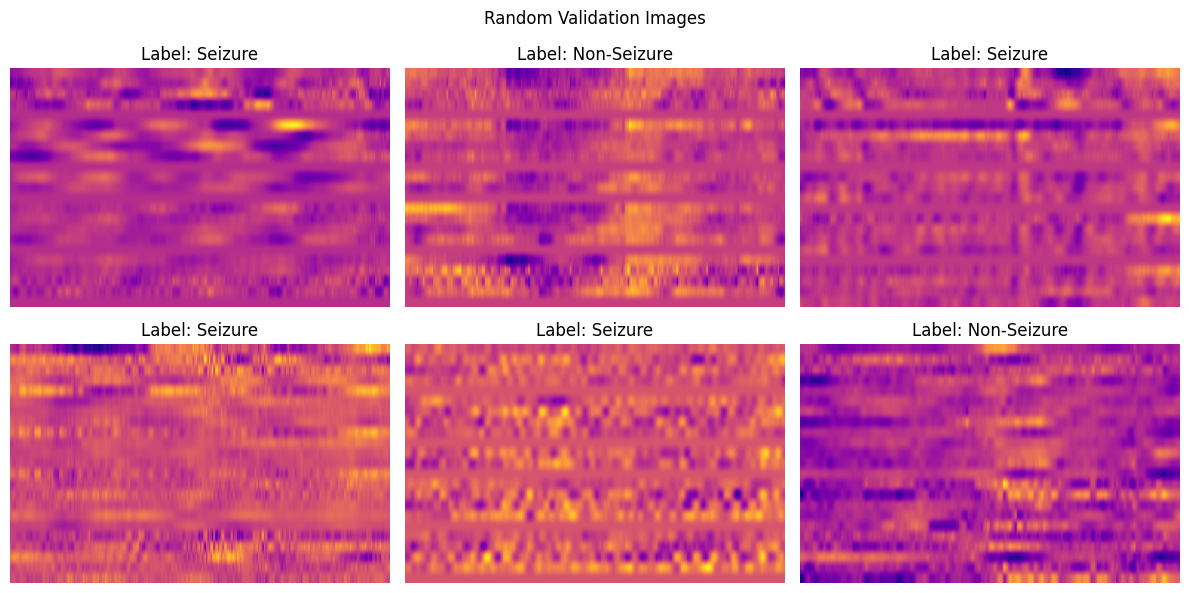

In [20]:
import seaborn as sns

# Generate random images and plots from test_data , val_data and test_data

def plot_random_images(data, labels, title, cmap='viridis'):
    plt.figure(figsize=(12, 6))
    for i in range(6):
        index = np.random.randint(0, len(data))
        plt.subplot(2, 3, i + 1)
        plt.imshow(data[index].numpy().reshape(23, 256), cmap=cmap, aspect='auto')
        plt.title(f'Label: {"Seizure" if labels[index] else "Non-Seizure"}')
        plt.axis('off')
    plt.suptitle(title)
    plt.tight_layout()
    plt.show()

# Display random images from training, validation, and test sets with different color maps
plot_random_images(X_train_cnn, y_train, 'Random Training Images', cmap='viridis')
plot_random_images(X_val_cnn, y_val, 'Random Validation Images', cmap='plasma')



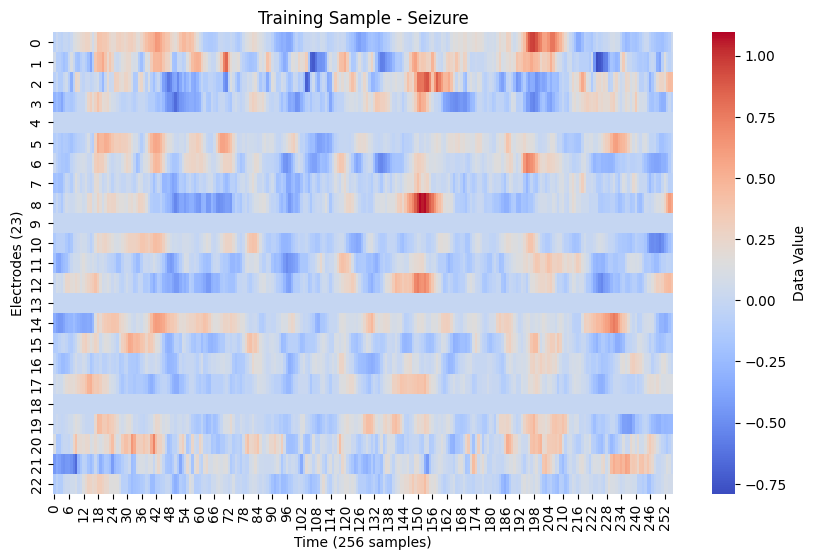

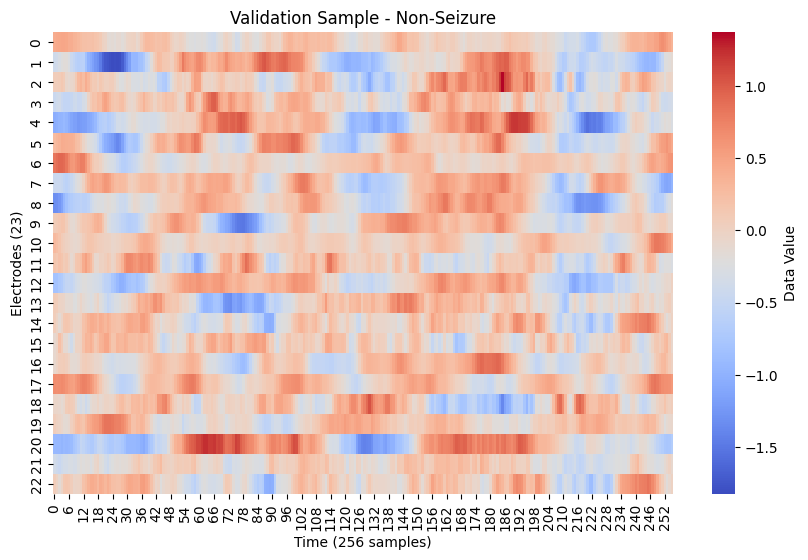

In [21]:
def plot_heatmap(data, labels, index, title):
    plt.figure(figsize=(10, 6))
    label = labels[index].numpy()  # Convert the tensor to a numpy array
    df = pd.DataFrame(data[index].numpy().reshape(23, 256))
    sns.heatmap(df, cmap='coolwarm', cbar=True, cbar_kws={'label': 'Data Value'})
    plt.title(f'{title} - {"Seizure" if label == 1 else "Non-Seizure"}')
    plt.xlabel('Time (256 samples)')
    plt.ylabel('Electrodes (23)')
    plt.show()

# Plot heatmap for random samples from training, validation, and test sets
plot_heatmap(X_train_cnn, y_train, np.random.randint(0, len(X_train_cnn)), 'Training Sample')
plot_heatmap(X_val_cnn, y_val, np.random.randint(0, len(X_val_cnn)), 'Validation Sample')

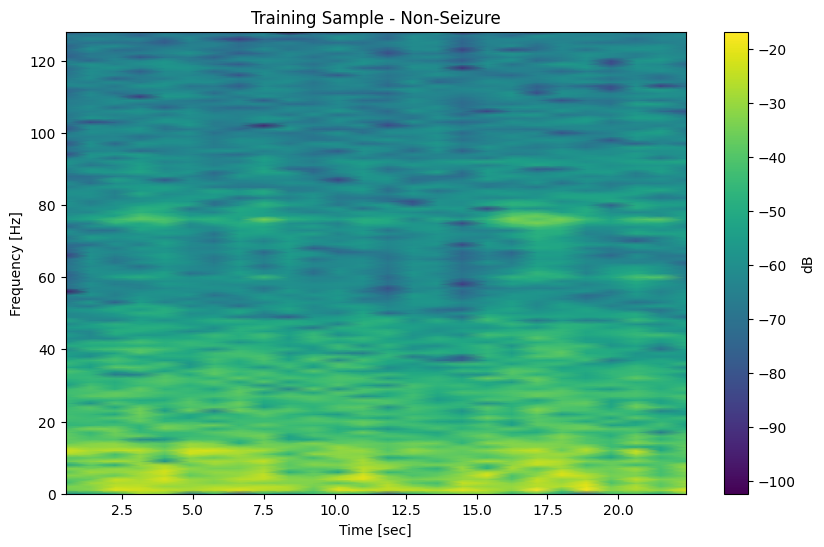

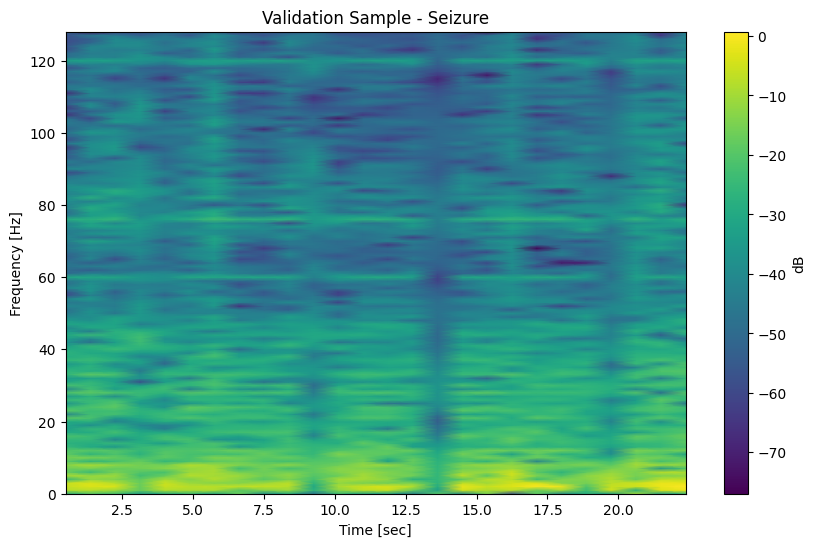

In [22]:
from scipy.signal import spectrogram

# Function to plot spectrogram
def plot_spectrogram(data, labels, index, title):
    plt.figure(figsize=(10, 6))
    label = labels[index].numpy()
    f, t, Sxx = spectrogram(data[index].numpy().flatten(), fs=256)
    plt.pcolormesh(t, f, 10 * np.log10(Sxx), shading='gouraud')
    plt.colorbar(label='dB')
    plt.title(f'{title} - {"Seizure" if label == 1 else "Non-Seizure"}')
    plt.ylabel('Frequency [Hz]')
    plt.xlabel('Time [sec]')
    plt.show()


# Plot spectrogram for random samples from training and validation sets
plot_spectrogram(X_train_cnn, y_train, np.random.randint(0, len(X_train_cnn)), 'Training Sample')
plot_spectrogram(X_val_cnn, y_val, np.random.randint(0, len(X_val_cnn)), 'Validation Sample')




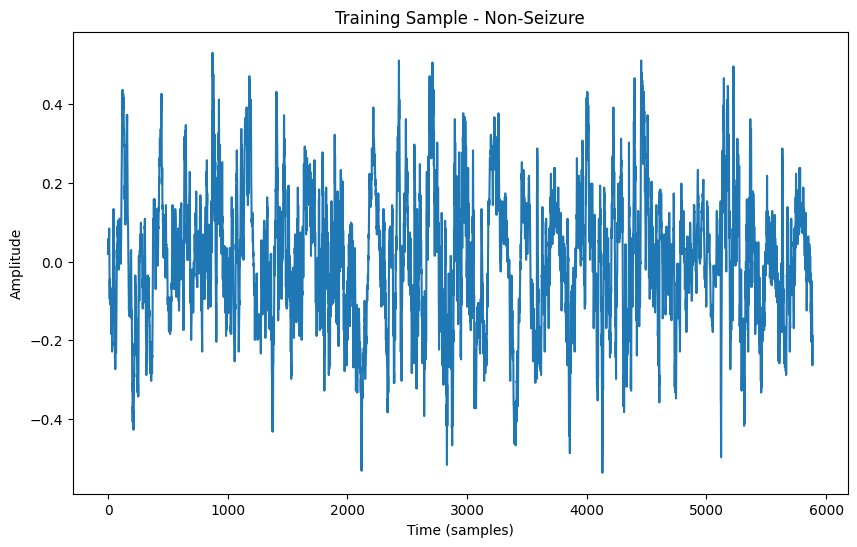

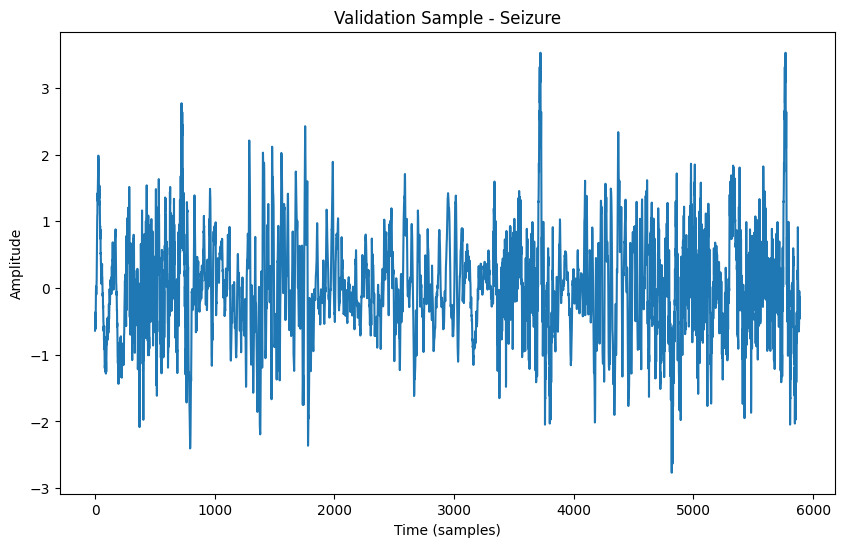

In [23]:
# Function to plot time-series data
def plot_time_series(data, labels, index, title):
    plt.figure(figsize=(10, 6))
    label = labels[index].numpy()
    plt.plot(data[index].numpy().flatten())
    plt.title(f'{title} - {"Seizure" if label == 1 else "Non-Seizure"}')
    plt.xlabel('Time (samples)')
    plt.ylabel('Amplitude')
    plt.show()

# Plot time-series data for random samples from training and validation sets
plot_time_series(X_train_cnn, y_train, np.random.randint(0, len(X_train_cnn)), 'Training Sample')
plot_time_series(X_val_cnn, y_val, np.random.randint(0, len(X_val_cnn)), 'Validation Sample')

In [25]:
# Optimizing/finding best Hyperparameters using Keras-Tuner

!pip install keras-tuner
from tensorflow import keras
import keras_tuner as kt
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

# Baseline model

baseline_model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(23, 256, 1)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

# Compiling the model

baseline_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Training the baseline model
baseline_model_history = baseline_model.fit(datagen.flow(X_train_cnn, y_train, batch_size=32),
                                    epochs=20,
                                    validation_data=(X_val_cnn, y_val))

# Evalute the baseline_model

baseline_loss , baseline_accuracy = baseline_model.evaluate(X_val_cnn, y_val)
print(f'Baseline Validation Accuracy {baseline_accuracy * 100:.2f}%')

# Generating classification report and confusion matrix for baseline model

baseline_y_pred = (baseline_model.predict(X_val_cnn) > 0.5).astype("int32")
print("Baseline model classification report:")
print(classification_report(y_val, baseline_y_pred))

print("Baseline model confusion matrix:")

print(confusion_matrix(y_val, baseline_y_pred))



Epoch 1/20
1178/1178 [==============================] - 33s 27ms/step - loss: 0.4622 - accuracy: 0.8157 - val_loss: 0.8791 - val_accuracy: 0.5705
Epoch 2/20
1178/1178 [==============================] - 33s 27ms/step - loss: 0.4169 - accuracy: 0.8292 - val_loss: 1.1285 - val_accuracy: 0.5807
Epoch 3/20
1178/1178 [==============================] - 31s 26ms/step - loss: 0.3913 - accuracy: 0.8335 - val_loss: 1.1602 - val_accuracy: 0.5874
Epoch 4/20
1178/1178 [==============================] - 34s 28ms/step - loss: 0.3737 - accuracy: 0.8410 - val_loss: 1.0337 - val_accuracy: 0.5886
Epoch 5/20
1178/1178 [==============================] - 31s 26ms/step - loss: 0.3704 - accuracy: 0.8412 - val_loss: 0.7738 - val_accuracy: 0.6342
Epoch 6/20
1178/1178 [==============================] - 32s 27ms/step - loss: 0.3638 - accuracy: 0.8445 - val_loss: 0.7606 - val_accuracy: 0.6765
Epoch 7/20
1178/1178 [==============================] - 31s 26ms/step - loss: 0.3527 - accuracy: 0.8496 - val_loss: 1.1450 -

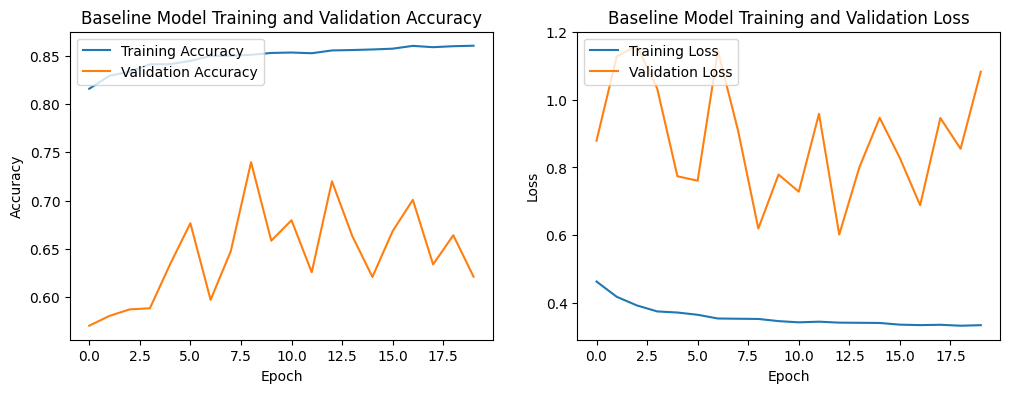

In [26]:
# plot baseline model training and validation accuracy and loss values

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)

plt.plot(baseline_model_history.history['accuracy'], label='Training Accuracy')
plt.plot(baseline_model_history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Baseline Model Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='upper left')

plt.subplot(1, 2, 2)
plt.plot(baseline_model_history.history['loss'], label='Training Loss')
plt.plot(baseline_model_history.history['val_loss'], label='Validation Loss')
plt.title('Baseline Model Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper left')

plt.show()

# Baseline model summary

In [27]:
print(baseline_model.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 21, 254, 32)       320       
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 10, 127, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_3 (Conv2D)           (None, 8, 125, 64)        18496     
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 4, 62, 64)         0         
 g2D)                                                            
                                                                 
 flatten_1 (Flatten)         (None, 15872)             0         
                                                                 
 dense_2 (Dense)             (None, 64)               

##Choosing hyperparameter values :

1. Number of Filter('conv_1_filter','conv_2_filter'):

*   Range: between 32 - 128
*   Reason: Lower values may not capture sufficient features while too high values can lead to overfitting and high computational cost

2. Kernel Size (conv_1_kernel, conv_2_kernel):

*   between 3 - 5
*   Reason: Smaller kernel capture fine details while larger kernels capture more context.

3. Units in Dense Layer ('dense_1_units'):

*   b/w 32 - 128
*   Reason: This controls the complexity of the network. Too few units might underfit, and too many might overfit

4. Optimizer ('optimizer'):

*   'adam','sgd'
*   Reason:Adam is popular for its adaptive learning rate. SGD is simple and effective, often leading to good generalization.







In [32]:
def build_model(hp):
    model = Sequential()

    # First 2d convolution matrix

    model.add(Conv2D(
        filters=hp.Int('conv_1_filter', min_value=32, max_value=128,step=16),
        kernel_size = hp.Choice('conv_1_kernel', values=[3, 5]),
        activation='relu',
        input_shape=(23, 256, 1)
    ))

    model.add(MaxPooling2D((2, 2)))

    # Second Convolution layer

    model.add(Conv2D(
        filters=hp.Int('conv_2_filter', min_value=32, max_value=128,step=16),
        kernel_size = hp.Choice('conv_2_kernel', values=[3, 5]),
        activation='relu'
    ))

    model.add(MaxPooling2D((2, 2)))

    # Flatten the output of the convolutional layers
    model.add(Flatten())

    # Dense layer
    model.add(Dense(units=hp.Int('units', min_value=32, max_value=128, step=16),
                    activation='relu'))

    model.add(Dropout(0.5))

    # Output layer
    model.add(Dense(1, activation='sigmoid'))

    # Compile the model
    model.compile(
        optimizer=hp.Choice('optimizer', values=['adam', 'sgd']),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )

    return model



In [33]:
tuner = kt.RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=5,     # number of different hyperparameter combinations to try
    executions_per_trial=1,    # number of times to train each model
    directory='hyperparameter_tuning_results',
    project_name='Epileptic_Seizure_Detection'
)


In [34]:
# Searching best hyperparameters on the training and validation data

tuner.search(X_train_cnn, y_train, epochs=5, validation_data=(X_val_cnn, y_val))

Trial 5 Complete [00h 00m 50s]
val_accuracy: 0.8668922781944275

Best val_accuracy So Far: 0.8668922781944275
Total elapsed time: 00h 06m 00s


In [35]:
 # Retrieveing the best hyperparameters found from the RandomSearch

 best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
 print(best_hps)


In [36]:
# Build and Train the model with best hyperparameters

tuned_model = tuner.hypermodel.build(best_hps)

tuned_history = tuned_model.fit(datagen.flow(X_train_cnn, y_train, batch_size=32),
                                    epochs=20,
                                    validation_data=(X_val_cnn, y_val))

Epoch 1/20
1178/1178 [==============================] - 37s 30ms/step - loss: 0.4643 - accuracy: 0.8134 - val_loss: 0.8733 - val_accuracy: 0.5964
Epoch 2/20
1178/1178 [==============================] - 34s 29ms/step - loss: 0.4252 - accuracy: 0.8232 - val_loss: 1.1267 - val_accuracy: 0.5787
Epoch 3/20
1178/1178 [==============================] - 36s 30ms/step - loss: 0.3959 - accuracy: 0.8311 - val_loss: 0.9147 - val_accuracy: 0.6165
Epoch 4/20
1178/1178 [==============================] - 34s 29ms/step - loss: 0.3843 - accuracy: 0.8368 - val_loss: 0.6675 - val_accuracy: 0.6393
Epoch 5/20
1178/1178 [==============================] - 35s 30ms/step - loss: 0.3715 - accuracy: 0.8403 - val_loss: 1.1503 - val_accuracy: 0.5739
Epoch 6/20
1178/1178 [==============================] - 36s 30ms/step - loss: 0.3692 - accuracy: 0.8418 - val_loss: 1.0058 - val_accuracy: 0.5964
Epoch 7/20
1178/1178 [==============================] - 35s 30ms/step - loss: 0.3617 - accuracy: 0.8425 - val_loss: 0.9739 -

In [37]:
# Evaluate the tuned model on validation set

tuned_loss, tuned_accuracy = tuned_model.evaluate(X_val_cnn, y_val)
print(f'Tuned Validation Accuracy {tuned_accuracy * 100:.2f}%')

# Generating classification report and confusion matrix for tuned model

tuned_y_pred = (tuned_model.predict(X_val_cnn) > 0.5).astype("int32")
print("Tuned model classification report:")
print(classification_report(y_val, tuned_y_pred))

print("Tuned model confusion matrix:")

print(confusion_matrix(y_val, tuned_y_pred))



111/111 [==============================] - 1s 5ms/step - loss: 0.9869 - accuracy: 0.6097
Tuned Validation Accuracy 60.97%
111/111 [==============================] - 0s 3ms/step
Tuned model classification report:
              precision    recall  f1-score   support

         0.0       0.56      0.99      0.72      1773
         1.0       0.98      0.23      0.37      1773

    accuracy                           0.61      3546
   macro avg       0.77      0.61      0.54      3546
weighted avg       0.77      0.61      0.54      3546

Tuned model confusion matrix:
[[1763   10]
 [1374  399]]


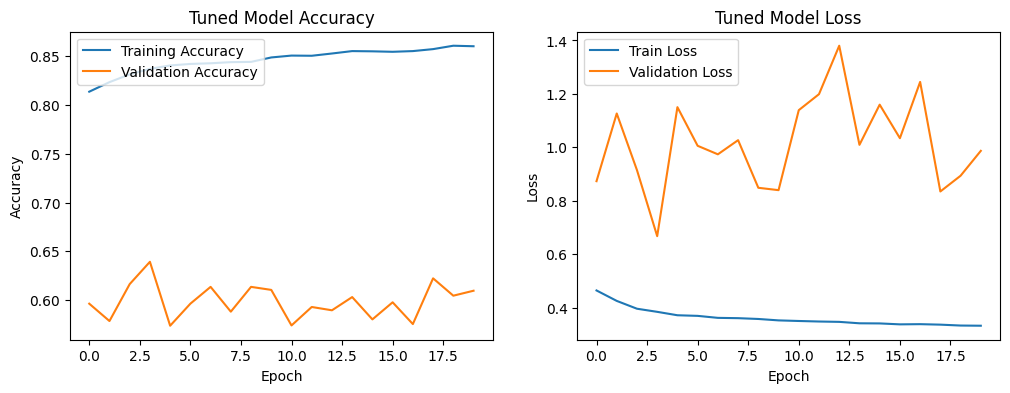

In [38]:
# plot tuned model training & validation accuracy and loss values

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)

plt.plot(tuned_history.history['accuracy'], label='Training Accuracy')

plt.plot(tuned_history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Tuned Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='upper left')

plt.subplot(1,2,2)
plt.plot(tuned_history.history['loss'], label='Train Loss')
plt.plot(tuned_history.history['val_loss'], label='Validation Loss')
plt.title('Tuned Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper left')

plt.show()

## Comparing Both the models i.e Baseline model and Tuned Model

Baseline Model Validation Accuracy 62.13%
Tuned Model Validation Accuracy 60.97%


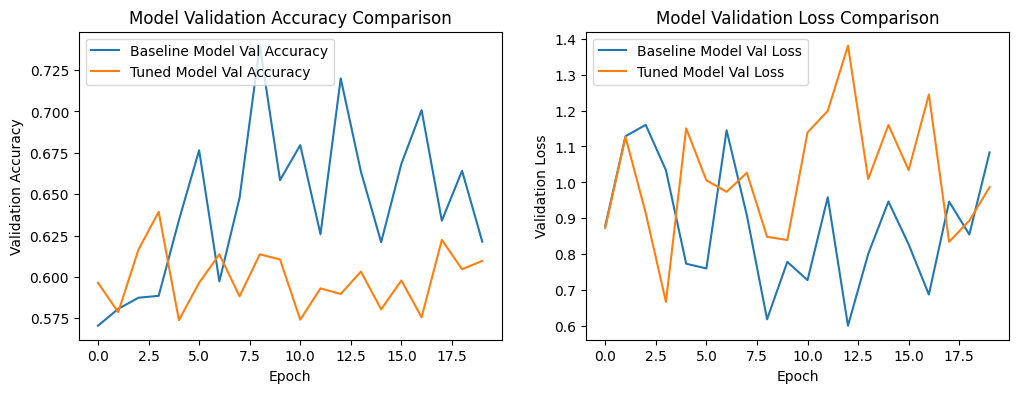

In [39]:
print(f'Baseline Model Validation Accuracy {baseline_accuracy * 100:.2f}%')
print(f'Tuned Model Validation Accuracy {tuned_accuracy * 100:.2f}%')

# plot training & validation accuracy and loss values for both models

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)

plt.plot(baseline_model_history.history['val_accuracy'], label='Baseline Model Val Accuracy')

plt.plot(tuned_history.history['val_accuracy'], label='Tuned Model Val Accuracy')

plt.title('Model Validation Accuracy Comparison')
plt.xlabel('Epoch')
plt.ylabel('Validation Accuracy')
plt.legend(loc='upper left')


plt.subplot(1,2,2)
plt.plot(baseline_model_history.history['val_loss'], label='Baseline Model Val Loss')
plt.plot(tuned_history.history['val_loss'], label='Tuned Model Val Loss')
plt.title('Model Validation Loss Comparison')
plt.xlabel('Epoch')
plt.ylabel('Validation Loss')
plt.legend(loc='upper left')

plt.show()